## 전처리 포함 테스트

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading data from /content/drive/MyDrive/model_test/colored_mnist_val_raw.npz...
Data shape: (10000, 28, 28, 3)

--- Preprocessing Pipeline Start ---


Extracting Color Features: 100%|██████████| 10000/10000 [00:00<00:00, 13937.95it/s]


--- Preprocessing Pipeline End ---

[Digit(HOG)] Evaluating...
Loading model from /content/drive/MyDrive/model_test/LightGBM_Digit_HOG.pkl...


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.7.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Accuracy: 0.9861
----------------------------------------
              precision    recall  f1-score   support

           0     0.9899    0.9949    0.9924       984
           1     0.9938    0.9908    0.9923       976
           2     0.9823    0.9882    0.9852      1013
           3     0.9844    0.9921    0.9883      1019
           4     0.9869    0.9810    0.9840      1002
           5     0.9929    0.9879    0.9904       993
           6     0.9951    0.9864    0.9907      1031
           7     0.9797    0.9857    0.9827       979
           8     0.9851    0.9737    0.9794       951
           9     0.9717    0.9800    0.9759      1052

    accuracy                         0.9861     10000
   macro avg     0.9862    0.9861    0.9861     10000
weighted avg     0.9861    0.9861    0.9861     10000

[BG Color] Evaluating...
Loading model from /content/drive/MyDrive/model_test/LightGBM_BG_Color.pkl...


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.7.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Accuracy: 1.0000
----------------------------------------
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      1407
           1     1.0000    1.0000    1.0000      1417
           2     1.0000    1.0000    1.0000      1408
           3     1.0000    1.0000    1.0000      1449
           4     1.0000    1.0000    1.0000      1500
           5     1.0000    1.0000    1.0000      1407
           6     1.0000    1.0000    1.0000      1412

    accuracy                         1.0000     10000
   macro avg     1.0000    1.0000    1.0000     10000
weighted avg     1.0000    1.0000    1.0000     10000

[FG Color] Evaluating...
Loading model from /content/drive/MyDrive/model_test/LightGBM_FG_Color.pkl...


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.7.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Accuracy: 1.0000
----------------------------------------
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      1473
           1     1.0000    1.0000    1.0000      1480
           2     1.0000    1.0000    1.0000      1392
           3     1.0000    1.0000    1.0000      1437
           4     1.0000    1.0000    1.0000      1433
           5     1.0000    1.0000    1.0000      1356
           6     1.0000    1.0000    1.0000      1429

    accuracy                         1.0000     10000
   macro avg     1.0000    1.0000    1.0000     10000
weighted avg     1.0000    1.0000    1.0000     10000



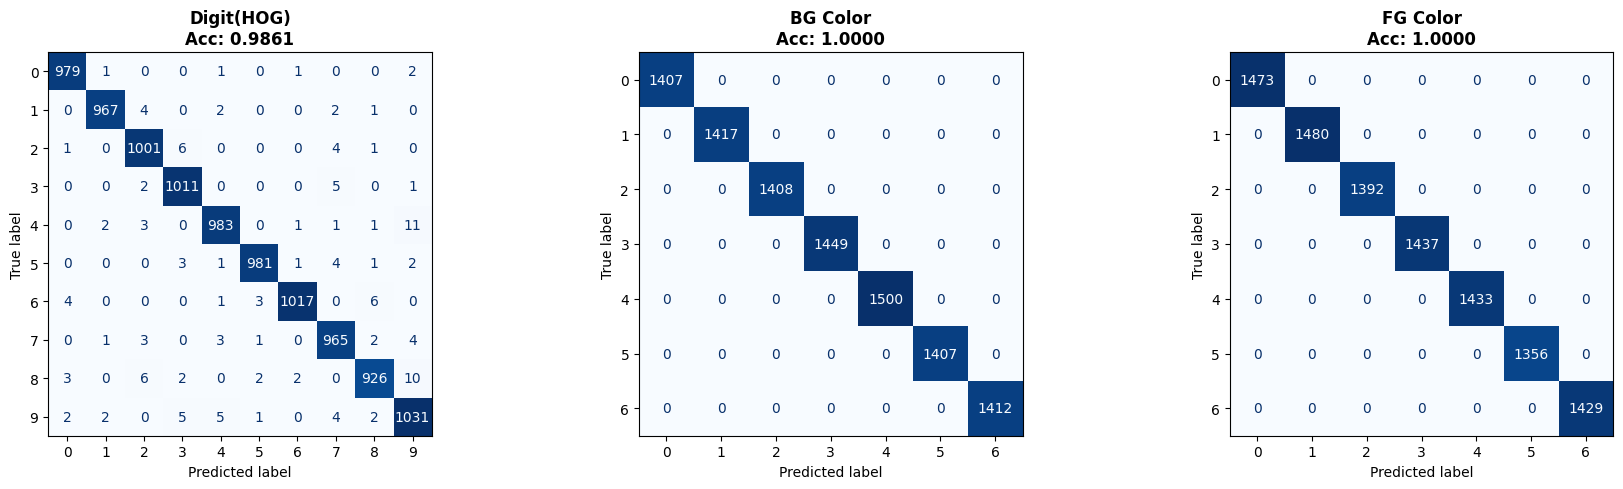


All evaluations completed.


In [13]:
import numpy as np
import joblib
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.ndimage import center_of_mass, shift
from skimage.feature import hog
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from google.colab import drive
drive.mount('/content/drive')

# 파일 경로 설정 (업로드된 파일명 기준)
BASE_DIR = '/content/drive/MyDrive/model_test'
file_path = os.path.join(BASE_DIR, 'colored_mnist_val_raw.npz')

# ==========================================
# 1. 전처리 함수 정의 (학습 때와 동일해야 함)
# ==========================================

def remove_background_corner_rule(images, patch_size=2, threshold=30, bg_value=0):
    """이미지 네 모서리의 색상을 평균내어 배경색으로 간주하고 제거"""
    N, H, W, C = images.shape
    out = np.zeros_like(images)
    for i in tqdm(range(N), desc="Background Removal"):
        img = images[i]
        is_float = img.max() <= 1.0
        img_uint = (img * 255).astype(np.uint8) if is_float else img.astype(np.uint8)

        # 네 코너의 평균 색상 계산
        tl = img_uint[0:patch_size, 0:patch_size, :]
        tr = img_uint[0:patch_size, W-patch_size:W, :]
        bl = img_uint[H-patch_size:H, 0:patch_size, :]
        br = img_uint[H-patch_size:H, W-patch_size:W, :]
        bg_color = np.mean(np.concatenate([tl.reshape(-1,3), tr.reshape(-1,3), bl.reshape(-1,3), br.reshape(-1,3)], axis=0), axis=0)

        # 배경색과 유사한 픽셀 마스킹
        mask_bg = np.linalg.norm(img_uint - bg_color, axis=2) < threshold
        img_uint[mask_bg] = bg_value
        out[i] = (img_uint.astype(np.float32)/255.0) if is_float else img_uint
    return out

def rgb_to_gray_max(images):
    """RGB 중 가장 큰 값을 선택하여 Grayscale 변환"""
    imgs = images.astype(np.float32)/255.0 if images.max() > 1.0 else images.astype(np.float32)
    return np.max(imgs, axis=3)

def binarize(images_gray, threshold=0.5):
    """이진화"""
    return (images_gray > threshold).astype(np.float32)

def center_images_com(images, size=28):
    """질량 중심(Center of Mass) 기반으로 이미지 중앙 정렬"""
    centered = []
    cy, cx = size / 2, size / 2
    for img in images:
        if np.sum(img) == 0:
            centered.append(img)
            continue
        com_y, com_x = center_of_mass(img)
        shifted = shift(img, shift=[cy-com_y, cx-com_x], order=0, mode='constant', cval=0)
        centered.append(shifted)
    return np.array(centered)

def extract_hog_features(images, ppc=4, cpb=2):
    """HOG 특징 추출"""
    feats = []
    for img in tqdm(images, desc="Extracting HOG"):
        feats.append(hog(img, pixels_per_cell=(ppc,ppc), cells_per_block=(cpb,cpb), visualize=False))
    return np.array(feats, dtype=np.float32)

def extract_color_features(images_color, images_gray, threshold=0.1):
    """Foreground(숫자)와 Background(배경)의 평균 색상 추출"""
    N, H, W, C = images_color.shape
    fg_features = np.zeros((N,3), dtype=np.float32)
    bg_features = np.zeros((N,3), dtype=np.float32)

    for i in tqdm(range(N), desc="Extracting Color Features"):
        img = images_color[i].astype(np.float32)
        gray = images_gray[i]

        # BG: 네 코너 영역 평균
        tl, tr = img[0:2,0:2,:], img[0:2,W-2:W,:]
        bl, br = img[H-2:H,0:2,:], img[H-2:H,W-2:W,:]
        bg_features[i] = np.mean(np.concatenate([tl.reshape(-1,3), tr.reshape(-1,3), bl.reshape(-1,3), br.reshape(-1,3)], axis=0), axis=0)

        # FG: 숫자가 있는 영역(Threshold 이상) 평균
        mask = gray > threshold
        fg_features[i] = np.mean(img[mask], axis=0) if np.sum(mask)>0 else bg_features[i]

    return fg_features, bg_features


# ==========================================
# 2. 데이터 로드 및 전처리 실행
# ==========================================

# 파일이 있는 폴더 경로
BASE_DIR = '/content/drive/MyDrive/model_test'

MODEL_PATHS = {
    "Digit(HOG)": "LightGBM_Digit_HOG.pkl",
    "BG Color": "LightGBM_BG_Color.pkl",
    "FG Color": "LightGBM_FG_Color.pkl"
}

print(f"Loading data from {file_path}...")
data = np.load(file_path)
X_test_raw = data['images']
y_test_digit = data['labels_digit']
y_test_fg = data['labels_fg']
y_test_bg = data['labels_bg']

print(f"Data shape: {X_test_raw.shape}")

print("\n--- Preprocessing Pipeline Start ---")
# 1. 배경 제거
X_test_nobg = remove_background_corner_rule(X_test_raw)
# 2. Grayscale & Binarization
X_test_gray = rgb_to_gray_max(X_test_nobg)
X_test_bin = binarize(X_test_gray)
# 3. Centering (숫자 중심 맞추기) -> Digit 분류용
X_test_centered = center_images_com(X_test_bin)
# 4. HOG Feature 추출
X_test_hog = extract_hog_features(X_test_centered)
# 5. Color Feature 추출 (원본 이미지 사용)
X_test_fg_feat, X_test_bg_feat = extract_color_features(X_test_raw, X_test_gray)
print("--- Preprocessing Pipeline End ---\n")


# ==========================================
# 3. 모델 로드 및 평가
# ==========================================

# 평가 루프를 위한 설정
tasks = [
    ("Digit(HOG)", X_test_hog, y_test_digit),
    ("BG Color",   X_test_bg_feat, y_test_bg),
    ("FG Color",   X_test_fg_feat, y_test_fg)
]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (task_name, X_data, y_true) in enumerate(tasks):
    file_name = MODEL_PATHS[task_name]

    # [수정된 부분] 폴더 경로와 파일 이름을 합쳐서 '전체 경로'를 만듭니다.
    full_model_path = os.path.join(BASE_DIR, file_name)

    print(f"[{task_name}] Evaluating...")
    print(f"Loading model from {full_model_path}...")

    # 모델 로드
    try:
        model = joblib.load(full_model_path) # 전체 경로로 로드
    except FileNotFoundError:
        print(f"Error: 파일을 찾을 수 없습니다 -> {full_model_path}")
        print("경로가 정확한지, 구글 드라이브에 파일이 해당 폴더에 있는지 확인해주세요.")
        continue

    # 예측
    y_pred = model.predict(X_data)

    # 정확도 출력
    acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {acc:.4f}")
    print("-" * 40)
    print(classification_report(y_true, y_pred, digits=4))

    # Confusion Matrix 시각화
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues', ax=axes[i], colorbar=False)
    axes[i].set_title(f"{task_name}\nAcc: {acc:.4f}", fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nAll evaluations completed.")

## 전처리 x 테스트

In [14]:
import numpy as np
import joblib
import os
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# ==========================================
# 1. 데이터 로드
# ==========================================

# 파일 경로 설정
BASE_DIR = '/content/drive/MyDrive/model_test'
DATA_PATH = os.path.join(BASE_DIR, 'colored_mnist_val_raw.npz')

MODEL_PATHS = {
    "Digit(HOG)": "LightGBM_Digit_HOG.pkl",
    "BG Color": "LightGBM_BG_Color.pkl",
    "FG Color": "LightGBM_FG_Color.pkl"
}

print(f"Loading data from {DATA_PATH}...")
try:
    data = np.load(DATA_PATH)
    X_test_raw = data['images'] # (10000, 28, 28, 3)
    y_test_digit = data['labels_digit']
    y_test_fg = data['labels_fg']
    y_test_bg = data['labels_bg']
    print(f"Data loaded successfully. Shape: {X_test_raw.shape}")
except Exception as e:
    print(f"데이터 로드 실패: {e}")
    exit()

# ==========================================
# 2. 전처리 없는 데이터 준비 (Flatten)
# ==========================================
# 모델은 2차원(행, 열) 데이터를 원하므로, 4차원 이미지를 1줄로 펴줍니다.
# (10000, 28, 28, 3) -> (10000, 2352)
X_test_flatten = X_test_raw.reshape(X_test_raw.shape[0], -1)

print(f"Raw Data Flattened Shape: {X_test_flatten.shape}")
print("주의: 이 데이터는 전처리되지 않은 원본 픽셀 데이터입니다.")


# ==========================================
# 3. 모델 로드 및 테스트 (전처리 X)
# ==========================================

tasks = [
    ("Digit(HOG)", y_test_digit),
    ("BG Color",   y_test_bg),
    ("FG Color",   y_test_fg)
]

print("\n" + "="*50)
print(" 전처리 없는 데이터로 테스트 시작 ")
print("="*50)

for task_name, y_true in tasks:
    file_name = MODEL_PATHS[task_name]
    full_model_path = os.path.join(BASE_DIR, file_name)

    print(f"\n[{task_name}] 모델 로드 중: {file_name}")

    try:
        model = joblib.load(full_model_path)
    except FileNotFoundError:
        print(f"Error: 파일을 찾을 수 없습니다 -> {full_model_path}")
        continue

    print(f"[{task_name}] 예측 시도 중 (Raw Data)...")

    try:
        # 전처리 없는 데이터를 바로 넣습니다.
        y_pred = model.predict(X_test_flatten)

        # 만약 우연히 차원이 맞아 돌아간다면 결과 출력
        acc = accuracy_score(y_true, y_pred)
        print(f"Accuracy: {acc:.4f}")
        print(classification_report(y_true, y_pred, digits=4))

    except Exception as e:
        # 차원 불일치 등으로 에러가 발생할 경우
        print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        print(f"[실패] 모델 실행 중 에러가 발생했습니다.")
        print(f"에러 메시지: {e}")
        print("-" * 50)
        print("원인 설명:")
        if "feature" in str(e).lower() or "shape" in str(e).lower():
            n_features_model = model.n_features_in_
            print(f"-> 모델은 {n_features_model}개의 특징(Feature)을 기대하고 있습니다.")
            print(f"-> 하지만 입력된 데이터는 {X_test_flatten.shape[1]}개의 픽셀 데이터입니다.")
            print("-> 모델이 학습된 방식(HOG/색상추출)과 입력 데이터가 다르기 때문입니다.")
        else:
            print("-> 데이터 형식이나 모델 호환성 문제입니다.")
        print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")

print("\n테스트 종료.")

Loading data from /content/drive/MyDrive/model_test/colored_mnist_val_raw.npz...
Data loaded successfully. Shape: (10000, 28, 28, 3)
Raw Data Flattened Shape: (10000, 2352)
주의: 이 데이터는 전처리되지 않은 원본 픽셀 데이터입니다.

 전처리 없는 데이터로 테스트 시작 

[Digit(HOG)] 모델 로드 중: LightGBM_Digit_HOG.pkl
[Digit(HOG)] 예측 시도 중 (Raw Data)...
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
[실패] 모델 실행 중 에러가 발생했습니다.
에러 메시지: X has 2352 features, but LGBMClassifier is expecting 1296 features as input.
--------------------------------------------------
원인 설명:
-> 모델은 1296개의 특징(Feature)을 기대하고 있습니다.
-> 하지만 입력된 데이터는 2352개의 픽셀 데이터입니다.
-> 모델이 학습된 방식(HOG/색상추출)과 입력 데이터가 다르기 때문입니다.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

[BG Color] 모델 로드 중: LightGBM_BG_Color.pkl
[BG Color] 예측 시도 중 (Raw Data)...
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
[실패] 모델 실행 중 에러가 발생했습니다.
에러 메시지: X has 2352 features, but LGBMClassifier is expecting 3 features as input.
--------------------------------------------------
원

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.7.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.7.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.12/di